/tmp/ipykernel_19/286281135.py:108: RuntimeWarning: divide by zero encountered in divide
  cosmic_ray = cosmic_ray_amplitude / ((self.wavelengths - self.wavelengths[position]) ** 2)
/tmp/ipykernel_19/286281135.py:111: RuntimeWarning: invalid value encountered in divide
  cosmic_ray = cosmic_ray / cosmic_ray.max()


  Spectrum_ID  Wavelength Intensity_Type  Intensity
0  Spectrum_1   -1.000000  Full_Spectrum   4.816384
1  Spectrum_1   -0.998045  Full_Spectrum   4.930225
2  Spectrum_1   -0.996090  Full_Spectrum   5.447240
3  Spectrum_1   -0.994135  Full_Spectrum   5.416530
4  Spectrum_1   -0.992180  Full_Spectrum   4.922343
Cosmic Ray Peaks for Spectrum 1:
Position: 0.9100684261974585, Intensity: 1.7249376075365839
Cosmic Ray Peaks for Spectrum 2:
Position: -0.7497556207233627, Intensity: 1.6556475610428456
Position: -0.8748778103616813, Intensity: 1.5444021764622158
Position: 0.21407624633431088, Intensity: 1.1534686696448222
Cosmic Ray Peaks for Spectrum 3:
Position: 0.5347018572825024, Intensity: 1.6833295725826178
Position: 0.6500488758553276, Intensity: 1.7426058859189661
Cosmic Ray Peaks for Spectrum 4:
Position: 0.02639296187683282, Intensity: 1.79530625149454
Position: 0.18084066471163251, Intensity: 3.1409617218024337
Position: 0.5034213098729228, Intensity: 2.1824785522921957
Position: 0.4

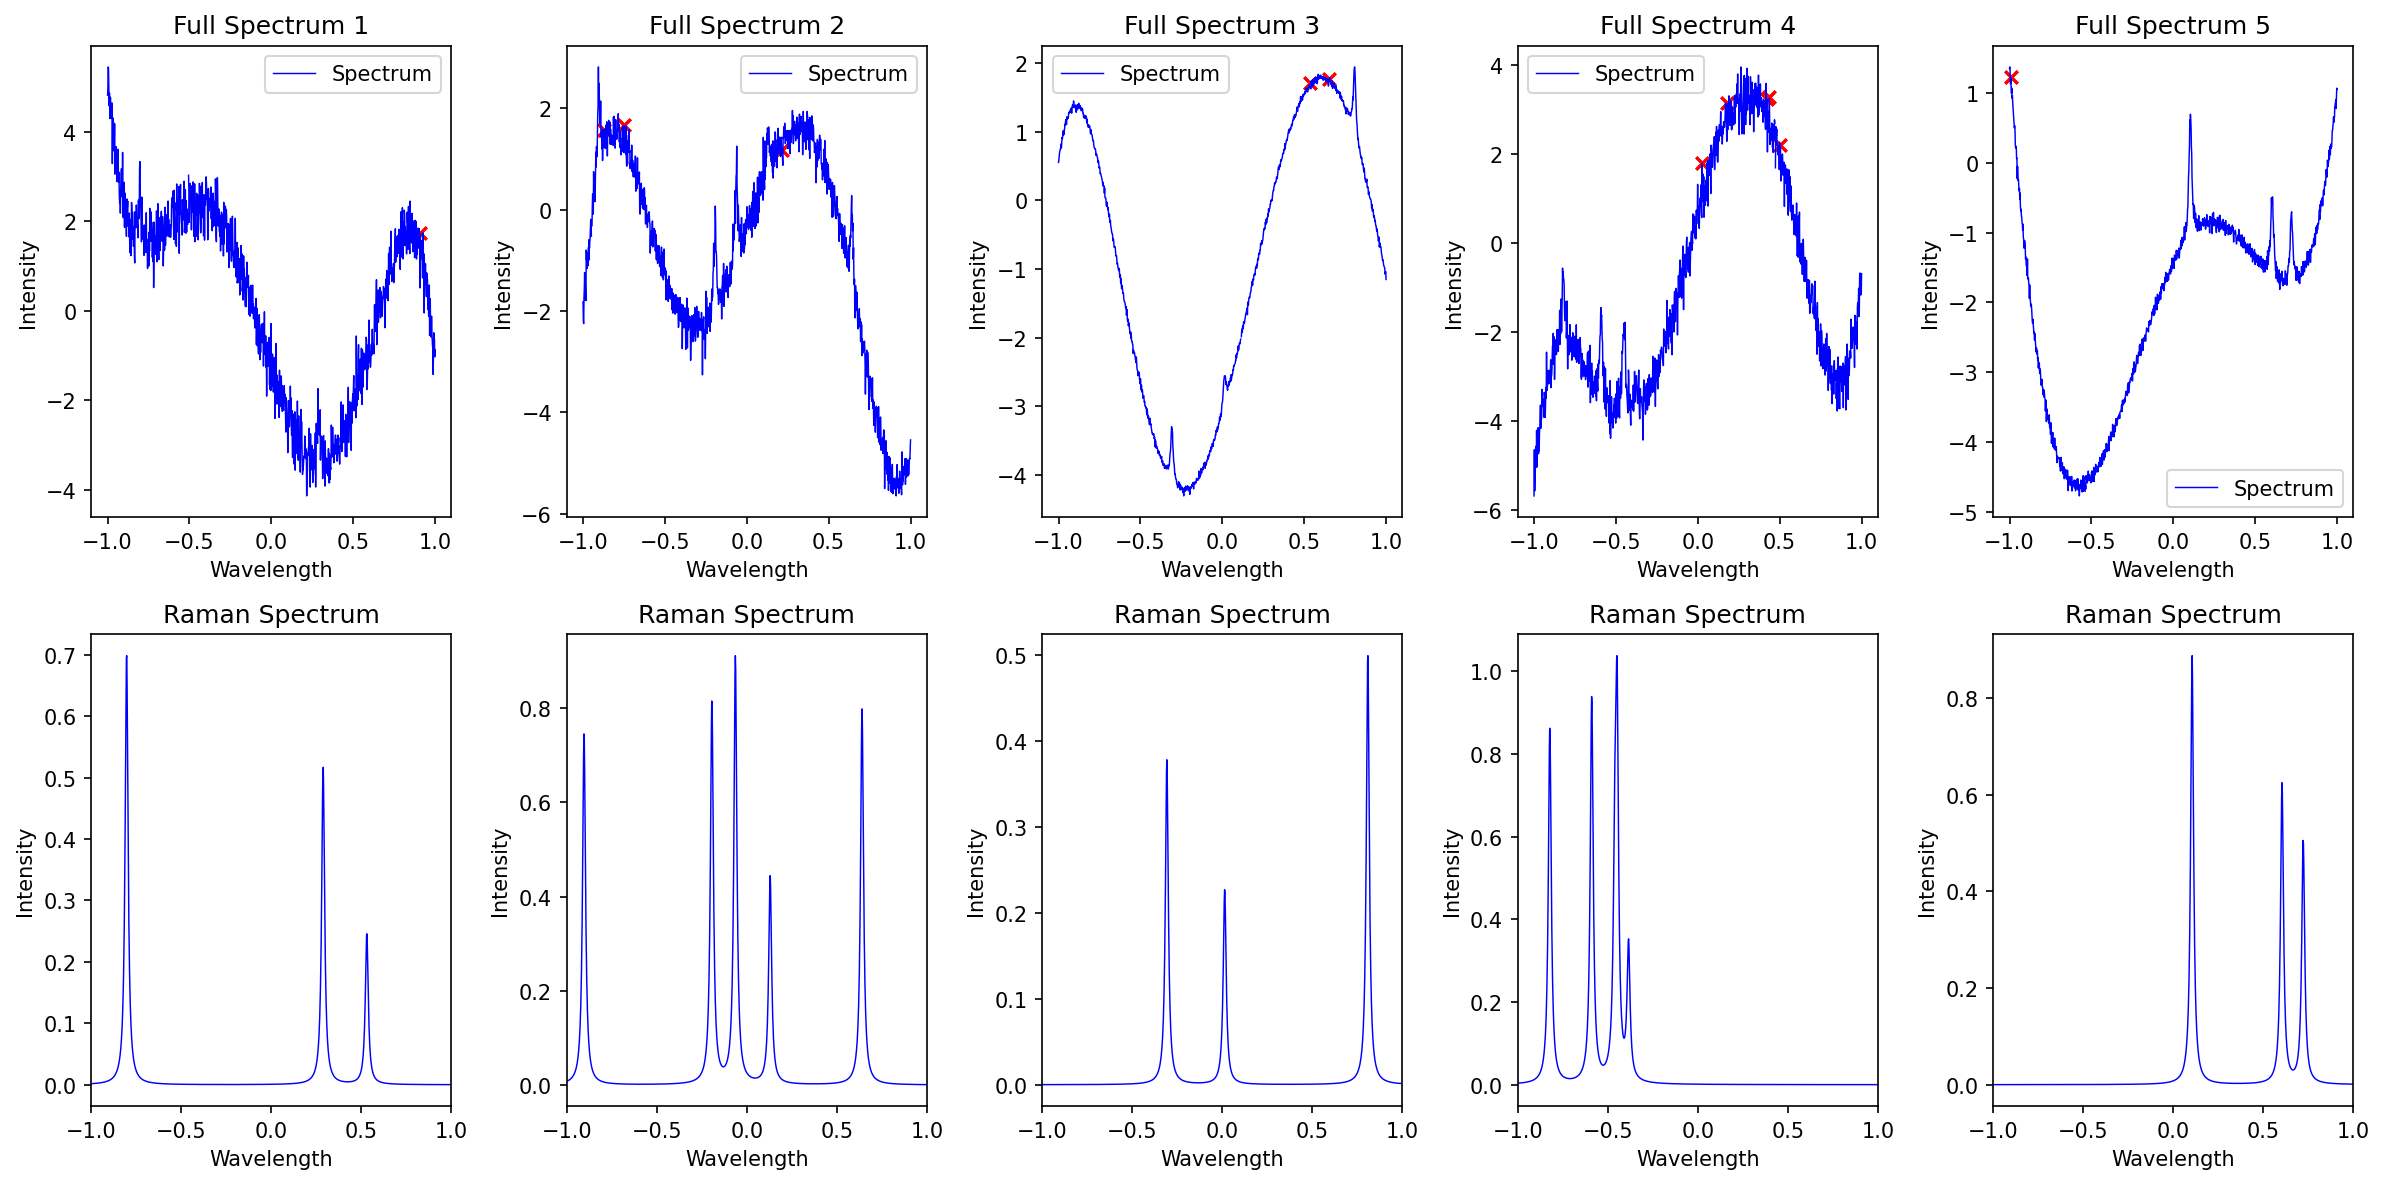

In [1]:
# SYNTHETIC SPECTRA, mark cosmic rays(correct, good resolution, very zoom) IN CONSTRUCTION
import numpy as np
import pandas as pd
import scipy.signal
import matplotlib.pyplot as plt

# 1. INPUT PARAMETERS
class SyntheticRamanSpectrum:
    def __init__(self, pixels, poly_order_range, num_peaks_range, snr_range, cosmic_ray_prob, num_spectra):
        self.pixels = pixels
        self.poly_order_range = poly_order_range
        self.num_peaks_range = num_peaks_range
        self.snr_range = snr_range
        self.cosmic_ray_prob = cosmic_ray_prob
        self.num_spectra = num_spectra
        self.wavelengths = np.linspace(-1, 1, self.pixels)
        self.full_spectra_list = []
        self.raman_spectra_list = []

    # 2. CHEBYSHEV BASELINE    
    def chebyshev_polynomial(self, x, *coefficients):
        order = len(coefficients)
        chebyshev_vals = np.zeros_like(x)
    
        for i in range(order):
            chebyshev_vals += coefficients[i] * np.cos(i * np.arccos(np.array(x)))
     
        return chebyshev_vals
    
    def generate_spectrum(self):
        # Randomly select polynomial order for Chebyshev baseline
        poly_order = np.random.randint(self.poly_order_range[-1], self.poly_order_range[1] + 1)

        # Initialize an empty array to store the Chebyshev coefficients
        cheby_baseline_coefficients = np.random.uniform(-1, 1, poly_order + 1)

        # Generate Chebyshev coefficients iteratively
        for i in range(poly_order + 1):
            cheby_baseline_coefficients[i] = np.random.uniform(-1, 1)

        # Generate Chebyshev baseline
        self.cheby_baseline = self.chebyshev_polynomial(self.wavelengths, *cheby_baseline_coefficients)
    
    # 3. LORENTZIAN PEAKS
    def add_lorentzian_peaks(self):
        # Define parameters for Lorentzian peaks
        num_peaks = np.random.randint(self.num_peaks_range[0], self.num_peaks_range[1] + 1)
        peak_amplitudes = np.random.uniform(0, 1, num_peaks)
        peak_positions = np.random.uniform(-1, 1, num_peaks)
        peak_width = 1 / (self.pixels * 0.1)

        # Initialize peaks array
        peaks = np.zeros_like(self.wavelengths)

        # Add Lorentzian peaks to spectrum
        for i in range(num_peaks):
            peaks += peak_amplitudes[i] * (peak_width ** 2) / ((self.wavelengths - peak_positions[i]) ** 2 + peak_width ** 2)

        # Update peaks attribute
        self.peaks = peaks

        # Add peaks to Chebyshev baseline
        self.peaky_cheby = self.peaks + self.cheby_baseline
    
    # 4. NOISE GENERATION
    def add_gaussian_noise(self, noise_amplitude_range=(0, 1)):
        # Calculate signal power
        signal_power = np.mean(np.abs(self.cheby_baseline + self.peaks) ** 2)

        # Calculate noise power based on SNR
        noise_power = signal_power / self.snr_range

        # Calculate standard deviation of noise
        noise_std = np.sqrt(noise_power)

        # Generate random noise amplitudes within specified range
        min_amp, max_amp = noise_amplitude_range
        noise_amplitudes = np.random.uniform(min_amp, max_amp)

        # Generate Gaussian noise samples
        noise = np.random.normal(0, noise_std, len(self.wavelengths))

        # Scale noise by noise amplitudes
        total_noise = noise * noise_amplitudes
        
        # Add noise to peaky cheby spectra
        self.noisy_peaky_cheby = self.peaky_cheby + total_noise

    # 5. COSMIC RAYS
    # Generate Cosmic Rays 
    # Lorentzian peak with a width of 0, y = 1 / (x - position)^2  
    # Cosmic ray amplitudes: randomized between 0.8 & L2-norm of complete signal

    def add_cosmic_rays(self, num_cosmic_rays):
        cosmic_rays_spectrum = self.noisy_peaky_cheby.copy()
    
        # Calculate L2-norm of complete signal
        l2_norm = np.linalg.norm(cosmic_rays_spectrum)
    
        for _ in range(num_cosmic_rays):
            # Generate random amplitude between 0.8 & L2-norm of complete signal
            cosmic_ray_amplitude = np.random.uniform(0.8, l2_norm)
        
            # Randomly select position for cosmic ray
            position = np.random.randint(0, len(cosmic_rays_spectrum))
        
            # Create cosmic ray using y = 1 / (x - position)^2  
            cosmic_ray = cosmic_ray_amplitude / ((self.wavelengths - self.wavelengths[position]) ** 2)

            # Normalize cosmic ray
            cosmic_ray = cosmic_ray / cosmic_ray.max()

            # Add cosmic ray to spectrum
            cosmic_rays_spectrum += cosmic_ray

        # Update full synthetic spectrum with cosmic rays
        full_spectrum = cosmic_rays_spectrum + self.noisy_peaky_cheby
        self.full_spectra_list.append(full_spectrum)

        # Update Raman spectrum (only peaks)
        raman_spectrum = self.peaks
        self.raman_spectra_list.append(raman_spectrum)

    def save_to_csv(self, filename='synthetic_spectra.csv'):
        # Create a list to store individual spectra as dictionaries
        spectra_data = []

        for i, (full_spectrum, raman_spectrum) in enumerate(zip(self.full_spectra_list, self.raman_spectra_list), start=1):
            # Create a dictionary for each data point in a spectrum
            for j, (wavelength, intensity) in enumerate(zip(self.wavelengths, full_spectrum)):
                data_point = {
                    'Spectrum_ID': f'Spectrum_{i}',
                    'Wavelength': wavelength,
                    'Intensity_Type': 'Full_Spectrum',
                    'Intensity': intensity
                }
                spectra_data.append(data_point)

            for j, (wavelength, intensity) in enumerate(zip(self.wavelengths, raman_spectrum)):
                data_point = {
                    'Spectrum_ID': f'Spectrum_{i}',
                    'Wavelength': wavelength,
                    'Intensity_Type': 'Raman_Spectrum',
                    'Intensity': intensity
                }
                spectra_data.append(data_point)

        # Convert list of dictionaries to a DataFrame
        df = pd.DataFrame(spectra_data)

        # Save DataFrame to CSV file
        df.to_csv(filename, index=False)

        return df

# Parameters
pixels = 1024
poly_order_range = (2, 5)
num_peaks_range = (3, 6)
snr_range = 20
cosmic_ray_prob = 0.1
num_spectra = 5

synthetic_data_generator = SyntheticRamanSpectrum(pixels, poly_order_range, num_peaks_range, snr_range, cosmic_ray_prob, num_spectra)

# Generate synthetic spectra
for _ in range(num_spectra):
    # Randomly sample parameter values within specified ranges
    synthetic_data_generator.generate_spectrum()
    synthetic_data_generator.add_lorentzian_peaks()
    synthetic_data_generator.add_gaussian_noise()
    
    # Generate a random number of cosmic rays between 1 & 5
    num_cosmic_rays = np.random.randint(1, 5)
    synthetic_data_generator.add_cosmic_rays(num_cosmic_rays)

# Save X & Y values
output_file_path = 'synthetic_spectra.csv'
df = synthetic_data_generator.save_to_csv(filename=output_file_path)

# Display DataFrame
print(df.head())

# Set up a figure with higher resolution (DPI)
plt.figure(figsize=(16, 8), dpi=150)

# Plot full synthetic spectra with cosmic rays marked
for i in range(num_spectra):
    plt.subplot(2, num_spectra, i + 1)

    # Plot with a smoother line and more data points
    plt.plot(synthetic_data_generator.wavelengths, synthetic_data_generator.full_spectra_list[i], color='blue', label='Spectrum', linewidth=0.7)

    # Identify cosmic ray positions based on local maxima
    peaks, _ = scipy.signal.find_peaks(synthetic_data_generator.full_spectra_list[i])

    # Set a threshold to distinguish cosmic rays from other peaks
    cosmic_ray_threshold = 0.9

    # Filter peaks to only include those above the threshold
    cosmic_ray_peaks = [peak for peak in peaks if synthetic_data_generator.full_spectra_list[i][peak] > cosmic_ray_threshold]

    # Randomly select up to 5 cosmic rays to mark
    num_cosmic_rays_to_mark = min(np.random.randint(1, 6), len(cosmic_ray_peaks))

    # Randomly shuffle the cosmic_ray_peaks array to select a random subset
    np.random.shuffle(cosmic_ray_peaks)

    # Mark cosmic ray positions with "x" symbols above the peaks
    for peak in cosmic_ray_peaks[:num_cosmic_rays_to_mark]:
        # Mark the cosmic ray with "x" above the peak
        plt.scatter(synthetic_data_generator.wavelengths[peak], synthetic_data_generator.full_spectra_list[i][peak] + 0.02, marker='x', color='red')

    # Adjust plot settings
    plt.title(f'Full Spectrum {i + 1}')
    plt.xlabel('Wavelength')
    plt.ylabel('Intensity')
    plt.legend()
    
    # Print peak information for visual inspection
    print(f'Cosmic Ray Peaks for Spectrum {i + 1}:')
    for peak in cosmic_ray_peaks[:num_cosmic_rays_to_mark]:
        print(f'Position: {synthetic_data_generator.wavelengths[peak]}, Intensity: {synthetic_data_generator.full_spectra_list[i][peak]}')

    # Mark cosmic ray positions with "x" symbols above the peaks
    for peak in cosmic_ray_peaks[:num_cosmic_rays_to_mark]:
        # Mark the cosmic ray with "x" above the peak
        plt.scatter(synthetic_data_generator.wavelengths[peak], synthetic_data_generator.full_spectra_list[i][peak] + 0.02, marker='x', color='red')

# Plot corrected spectra
for i in range(num_spectra):
    plt.subplot(2, num_spectra, i + num_spectra + 1)
    plt.plot(synthetic_data_generator.wavelengths, synthetic_data_generator.raman_spectra_list[i], color='blue', linewidth=0.7)
    plt.title('Raman Spectrum')
    plt.xlabel('Wavelength')
    plt.ylabel('Intensity')
    plt.xlim(synthetic_data_generator.wavelengths.min(), synthetic_data_generator.wavelengths.max())  # Set full wavelength range

# Adjust layout
plt.tight_layout()
plt.show()